## __proteinSSpredictor__

This projects constitutes a final project for Data Science Bootcamp organised by Sages and aims at providing a deep-learning-based approach to predict secondary structure of the protein based on its primary sequence of the amino acids.

## __Table of contents__
1. Abstract
2. Source of raw sequences
3. Curation of the dataset
4. Prerequisites
5. Exploration of preprocessed dataset for modeling
6. Raw data processing
7. Model training
8. Where is the model making errors?
9. Summary
10. References

## __1. Abstract__

to do

## __2. Source of raw sequences__

Preparation of the updated dataset analogous to https://www.kaggle.com/alfrandom/protein-secondary-structure

Following steps from https://github.com/zyxue/pdb-secondary-structure the secondary structure data was downloaded by

`DATE_STAMP=$(date  +'%Y-%m-%d')
wget https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz -O ${DATE_TAMP}-ss.txt.gz`

Further, data was transformed to csv file analogously to https://github.com/zyxue/pdb-secondary-structure using self-implemented method (see below for more details).

## __3. Curation of the sequence dataset__ 

Further, recent PISCES data with removed peptides with high sequence similarity was downloaded from http://dunbrack.fccc.edu/Guoli/pisces_download.php

Selected precompiled CulledPDB for further modeling was generated with following criteria:

- percentage identity cutoff: 30%
- the resolution cutoff:      2.0 Å
- the R-factor cutoff:        0.25
- date of generation:         2021/07/02
- the number of sequences:    10870


## __4. Prerequisites__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## __4. Raw data processing__
At this point the raw sequences were converted to CSV file, translated to 3 letters representation, and combined with culledPDB list with reduced sequence identity to improve the model quality

In [2]:
from tools import process_raw_data

In [3]:
processing = process_raw_data.Sequences()

In [4]:
# %time sequences_df = processing.process_raw_sequences('../data/2021-07-09-ss.txt.gz')

In [5]:
#optional for faster processing:
sequences_df = pd.read_csv('../data/2021-07-09-ss.csv')

The set of raw sequences before processing with CulledPDB dataset contains 477154 and includes information about the sequence PDB ID code, protein chain and its primary sequence together with the secondary structure sequence

In [6]:
sequences_df.shape

(477154, 4)

In [7]:
sequences_df.head()

,pdb_id,chain,sequence,secondary_struct
0,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
1,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCTTTHHHHH...
2,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
3,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCCCCCCCCHHHHH...
4,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...


In [8]:
pisces_df = processing.clean_pisces(pisces_file='../data/cullpdb_pc30_res2.0_R0.25_d2021_07_02_chains10870.gz')

In [9]:
pisces_df.head()

,length,source,resolution,R_value,R_free,pdb_id,chain
0,108,XRAY,2.0,0.21,0.25,1A1X,A
1,148,XRAY,1.8,0.19,0.24,1A3A,A
2,163,XRAY,1.8,0.21,0.30,1A73,A
3,226,XRAY,1.9,0.19,0.22,1A8L,A
4,1073,XRAY,1.8,0.19,1.00,1A9X,C


The culledPDB set containts 10870 items (PDB databases records filtered by the resolution, R-value and the 30% sequence identity). It contains information about protein PDB ID code, protein chain, method used for its determination, R-value, R-value free and the length of the sequence.

In [10]:
pisces_df.shape

(10870, 7)

In [11]:
combined_df = processing.combine_pdb_pisces(sequences_df=sequences_df, pisces_df=pisces_df)

In [12]:
combined_df.head()

,pdb_id,chain,sequence,secondary_struct,length,source,resolution,R_value,R_free
0,1A1X,A,GSAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQ...,CCCCCCCCCCCSEEEEEETTEEEETTSCEEEEEEEECSSCEEEEEE...,108,XRAY,2.0,0.21,0.25
1,1A3A,A,MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAM...,CCCCCCCCGGGEECSCCCSSHHHHHHHHHHHHHHTTSBCTHHHHHH...,148,XRAY,1.8,0.19,0.24
2,1A73,A,MALTNAQILAVIDSWEETVGQFPVITHHVPLGGGLQGTLHCYEIPL...,CCCCHHHHHHHHHHHHHHHTTSCEEEEEEEEETTEEEEEEEEBCCS...,163,XRAY,1.8,0.21,0.30
3,1A8L,A,MGLISDADKKVIKEEFFSKMVNPVKLIVFVRKDHCQYCDQLKQLVQ...,CCSSCHHHHHHHHHHTGGGCCSCEEEEEEECSSSCTTHHHHHHHHH...,226,XRAY,1.9,0.19,0.22
4,1A9X,F,IKSALLVLEDGTQFHGRAIGATGSAVGEVVFNTSMTGYQEILTDPS...,CCEEEEEETTCCEEEEEECSCSEEEEEEEEEECCSSCHHHHHTCGG...,379,XRAY,1.8,0.19,1.00


In [13]:
combined_df.shape

(10186, 9)

While intersecting raw sequences and culledPDB dataset by protein PDB ID codes and chains, we obtain slightly smaller set (10186) in then the original culledPDB (10870) due to some mismatches in the chain IDs

In [14]:
print(sorted(pisces_df.chain.unique()))
print(f'amount of unique chain IDs in PISCES dataset: {len(pisces_df.chain.unique())}')

['1', '2', '3', '4', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
amount of unique chain IDs in PISCES dataset: 30


In [15]:
print(sorted(sequences_df.chain.unique()))
print(f'amount of unique chain IDs in dataset of raw sequences: {len(sequences_df.chain.unique())}')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
amount of unique chain IDs in dataset of raw sequences: 36


As the protein secondary structure can be represented in the extended form containing 8 secondary structure types (Q8) and simplified, containing only 3 secondary structure types (Q3), we create new column with the simplified version for modeling

Q8: Q3

__helices__ G, H, I: H

__sheet__ B, E: E

__coil__ T, S, C: C

Additionally, we get rid of the remaining columns and keep just PDB ID code, sequence, extended (Q8) secondary structure representation and simplified (Q3) representation as pdb_id, seq, sst_q8 and sst_q3, respectively:

In [16]:
processes_sequeces = processing.generate_seq_q8_q3_representation(combined_df)

In [17]:
processes_sequeces

,pdb_id,seq,sst_q8,sst_q3
0,1A1X,GSAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQ...,CCCCCCCCCCCSEEEEEETTEEEETTSCEEEEEEEECSSCEEEEEE...,CCCCCCCCCCCCEEEEEECCEEEECCCCEEEEEEEECCCCEEEEEE...
1,1A3A,MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAM...,CCCCCCCCGGGEECSCCCSSHHHHHHHHHHHHHHTTSBCTHHHHHH...,CCCCCCCCHHHEECCCCCCCHHHHHHHHHHHHHHCCCECCHHHHHH...
2,1A73,MALTNAQILAVIDSWEETVGQFPVITHHVPLGGGLQGTLHCYEIPL...,CCCCHHHHHHHHHHHHHHHTTSCEEEEEEEEETTEEEEEEEEBCCS...,CCCCHHHHHHHHHHHHHHHCCCCEEEEEEEEECCEEEEEEEEECCC...
3,1A8L,MGLISDADKKVIKEEFFSKMVNPVKLIVFVRKDHCQYCDQLKQLVQ...,CCSSCHHHHHHHHHHTGGGCCSCEEEEEEECSSSCTTHHHHHHHHH...,CCCCCHHHHHHHHHHCHHHCCCCEEEEEEECCCCCCCHHHHHHHHH...
4,1A9X,IKSALLVLEDGTQFHGRAIGATGSAVGEVVFNTSMTGYQEILTDPS...,CCEEEEEETTCCEEEEEECSCSEEEEEEEEEECCSSCHHHHHTCGG...,CCEEEEEECCCCEEEEEECCCCEEEEEEEEEECCCCCHHHHHCCHH...
...,...,...,...,...
10181,7BU2,MSMIKSYAAKEAGGELEVYEYDPGELRPQDVEVQVDYCGICHSDLS...,CCCEEEEEESSTTCCEEEEEECCCSCCTTEEEEEEEEEEECHHHHH...,CCCEEEEEECCCCCCEEEEEECCCCCCCCEEEEEEEEEEECHHHHH...
10182,7BVD,MQTTANHSSRSTQTGTRAHGAALAETTSREDFRALATEHRVVPVIR...,CCCCCCCCCCCCCCCCCCCCCCTTCCCCHHHHHHHHTTCSEEEEEE...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHCCCCEEEEEE...
10183,7BYW,MRGSHHHHHHSGQRMGMVIGIKPEHIDEYKRLHAAVWPAVLARLAE...,CCCCCCCCCCCCCEEEEEEEECGGGHHHHHHHHTTCCHHHHHHHHH...,CCCCCCCCCCCCCEEEEEEEECHHHHHHHHHHHCCCCHHHHHHHHH...
10184,7ODC,MSSFTKDEFDCHILDEGFTAKDILDQKINEVSSSDDKDAFYVADLG...,CCEEEETTEEEEEECSSCCHHHHHHHHHCCCCCCCCCCCEEEEEHH...,CCEEEECCEEEEEECCCCCHHHHHHHHHCCCCCCCCCCCEEEEEHH...


Now, I am checking whether all representations of each protein in my dataset have complementary length

In [18]:
test_df = pd.DataFrame()
test_df['seq_len'] = [len(x) for x in processes_sequeces.seq]
test_df['sst_q8_len'] = [len(x) for x in processes_sequeces.sst_q8]
test_df['sst_q3_len'] = [len(x) for x in processes_sequeces.sst_q3]

In [19]:
processes_sequeces['pdb_id'][(test_df.seq_len != test_df.sst_q8_len) | (test_df.seq_len != test_df.sst_q3_len)]

Series([], Name: pdb_id, dtype: object)

In [20]:
processes_sequeces = processes_sequeces.assign(length=test_df.seq_len)

There are no mismatches between representations, hence I proceed further. Sequences can potentially contain non-standard amino acids (https://www.samformat.info/IUPAC-ambiguity-codes).

Standard set includes 20 types: 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'

Non-standard amino acids may include: 'B', 'J', 'O', 'U', 'Z' and 'X', where the last represents unspecified or unknown (potentially missing type). Let's have a look on those.

In [21]:
nonstandard_aa = 'BJOUZX'
contains_nonstandard_aa = []
nonstandard_types = []
for sequence in processes_sequeces.seq:
    i = 0
    ns_types = ''
    for letter in sequence:
        if letter in nonstandard_aa:
            i += 1
            ns_types += letter
    contains_nonstandard_aa.append(i)
    nonstandard_types.append(ns_types)
processes_sequeces = processes_sequeces.assign(contains_nonstandard_aa = contains_nonstandard_aa)
processes_sequeces = processes_sequeces.assign(nonstandard_types = nonstandard_types)

In [22]:
processes_sequeces[processes_sequeces.contains_nonstandard_aa > 0].shape

(71, 7)

We can observe, that 71 sequences contain nonstandard amino amids, I will have a closer look at those which have more of them, focusing especially on the unknown (X) 

In [23]:
processes_sequeces[processes_sequeces.contains_nonstandard_aa > 1]

,pdb_id,seq,sst_q8,sst_q3,length,contains_nonstandard_aa,nonstandard_types
906,1SN9,XYRIPSYDFADELAKLLRQAAGX,CCEETTEEHHHHHHHHHHHHTCC,CCEECCEEHHHHHHHHHHHHCCC,23,2,XX
2135,2O5G,XARRKWQKTGHAVRAIGRLSX,CCHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHCC,21,2,XX
2140,2O6N,XAEIEQAKKEIAYLIKKAKEEILEEIKKAKQEIAX,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,35,2,XX
2516,2RKZ,XETLTGQYDKNLVTTVEEEYDSX,CCCEEECSCTTSCCEEEEECCCC,CCCEEECCCCCCCCEEEEECCCC,23,2,XX
2801,2XSK,MGSSQITFNTTQQGDMYTIIPEVTLTQSULURVQILSLREGSSGQS...,CCCCEEEEEEEEETTEEEEEEEEECSSCEEEEEEEEEEEECSSCEE...,CCCCEEEEEEEEECCEEEEEEEEECCCCEEEEEEEEEEEECCCCEE...,110,2,UU
3210,3CAL,XKGIVTGAVSDHTTVEDTKX,CCCCEEECCSSCEEEECCCC,CCCCEEECCCCCEEEECCCC,20,2,XX
3213,3CAY,XAXAEAAEKAAKYAAEAAEKAAKAXAX,CCHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHCC,27,4,XXXX
4431,3O3Y,XTTWEAWDXAIAEYAXRIEXLIXAAQEQQEKNEXALXELX,CCCTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSCCC,CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC,40,8,XXXXXXXX
4933,3U5S,SMRTQQKRDTKFREDUPPDREELGRHSWAVLHTLAAYYPDLPTPEQ...,CCCCSCGGGTCCCSSSCCCHHHHHHHHHHHHHHHHHTSCSSCCHHH...,CCCCCCHHHCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHH...,126,6,UUUUUU
5083,3W19,XNNLLRAIEAQQHLLQLTVWGIKQLQARILAVERYLKDQX,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,40,2,XX


In [24]:
processes_sequeces[processes_sequeces.contains_nonstandard_aa > 4]

,pdb_id,seq,sst_q8,sst_q3,length,contains_nonstandard_aa,nonstandard_types
4431,3O3Y,XTTWEAWDXAIAEYAXRIEXLIXAAQEQQEKNEXALXELX,CCCTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSCCC,CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCC,40,8,XXXXXXXX
4933,3U5S,SMRTQQKRDTKFREDUPPDREELGRHSWAVLHTLAAYYPDLPTPEQ...,CCCCSCGGGTCCCSSSCCCHHHHHHHHHHHHHHHHHTSCSSCCHHH...,CCCCCCHHHCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHH...,126,6,UUUUUU
7112,4Z0W,XAPAPFVPAAXAVXLAXLAALXG,CCCTTTGGGGGGGGGGGGGGGCC,CCCCCCHHHHHHHHHHHHHHHCC,23,5,XXXXX
9174,6FHN,GVVQSVNVSQAGYSSNDFKTATVTASDKLSDTSYQILQGTTVIATG...,CCEEEEECCTTCEETTSCCEEEEEESSCCSCCEEEEESSSSEEEEE...,CCEEEEECCCCCEECCCCCEEEEEECCCCCCCEEEEECCCCEEEEE...,1009,33,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
9259,6GME,XXXXXXXXXXXXXXXXXXINFKQAEKMMETMDQGDVIIRPSSKGEN...,CCCCCCCCCCCCCEEECCCCHHHHHHHHHHSCTTCEEEEECSSCTT...,CCCCCCCCCCCCCEEECCCCHHHHHHHHHHCCCCCEEEEECCCCCC...,201,18,XXXXXXXXXXXXXXXXXX


In [25]:
processes_sequeces.seq[processes_sequeces.pdb_id == '6FHN'].values

array(['GVVQSVNVSQAGYSSNDFKTATVTASDKLSDTSYQILQGTTVIATGTMKDEGYVWGKYVYSIDFSSVTATGTNFTIRSNGVSSYTFPIQTNMWNEYKDEMTAFYRLLRTTDTFAAYPAGYSNIAPSNKILHPDSFLDDAFSPDRTTHYDLTGGWFDAGDYGKYGGNQWVQGNIAISYLRHASSAAVNFDKDTNGIPDLVDEAIFGSQYLVKFANQLGGAIHNILRKGGFVLPHKVTDNVPGNTDDRALEAVEAVGGSGKSSGSLAATARAIRTAIAGGKVAANKVAQLQTLANEFQAAAIIFYNYTLTHQSGNHGSYGTMNNGGIANPLLWAEVQLYLLTGDAAYKTQAQTRINAINEAYVSSTNYWDMHPIALAEFYPVADSAIKTKIQSILKHQAYYFITLMDETPYGVLNQFGNFGVNEPHASYMADLLRYYELFNDPVALRAAKKALYWIVGNNPWNISWVSGVGSNFTDFLHTRLDEEAYSQTNTGVVLPGAMVSGPNIKDPNNKLSSSPWYEDKPIWADDTNQWRYNEYSVSIQTGLFYTIMGLSALGGNASTGGAEPVKLPITWPIIGDYVTGDVTVFAQPEGSLSNVSANGIVLSPSDGVYTTTVSTSADAPYTERKVQIKGTDDSGFTTYSNTHFTVAPALPDPSHPLLFDDFNQKGIWGSQKLDWVNWYNQNGGTASYTRTTVDTRTVGKFAHTPAATTSKAKFQPWKYNANLNGYRYLNFTMKNPGYPNTKIRIAANDGTKSVNLTSGEVAISSTWTTYQYDLNLHPTLNKSNVLIEVWLSNPTAGAYGEILIDEISAVNTNSGTAPTLSATGVNASIGNQSTVFTYTATYTDANNQAPFDVQVVIDGVIRSMTAADPTDTTYSDGRVYTYATTLPVGTHKFYFRTTDTTTNFVSTSVQTGPTVIRNKLEAEVLSINLTNYTHAVKDNADASGGKYRLFNGRQANDYIEYAVNVPKAGTYQVSAXXXXXXXXXXXXXXXXX

In [26]:
processes_sequeces.seq[processes_sequeces.pdb_id == '6GME'].values

array(['XXXXXXXXXXXXXXXXXXINFKQAEKMMETMDQGDVIIRPSSKGENHLTVTWKVSDGIYQHVDVREEGKENAFSLGATLWINSEEFEDLDEIVARYVQPMASFARDLLNHKYYQDCSGGDRKKLEELLIKTKKEKPTFIPYFICACKELPGKFLLGYQPRGKPRIEYVTVTPEGFRYRGQIFPTVNGLFRWFKDHYQDPVP'],
      dtype=object)

There are two sequences (6FHN and 6GME) in the dataset which contains significant amount of the unknown residues at the beginning or end, which most likely is conditioned by high mobility of these regions preventing correct assignment of the amino acid type, which affects the quality of the DSSP secondary structure prediciton, so I will remove these two sequences from the dataset, as they are most likely of lower quality besides their relatively high resolution as filtered in CulledPDB from PISCES.

In [27]:
processes_sequeces = processes_sequeces.drop(processes_sequeces[processes_sequeces.contains_nonstandard_aa > 10].index)

## __5. Exploration of preprocessed dataset for modeling__

I will now have a brief look on prepared sequences, which I will later use while evaluating the model quality

In [28]:
from tools import visualizer

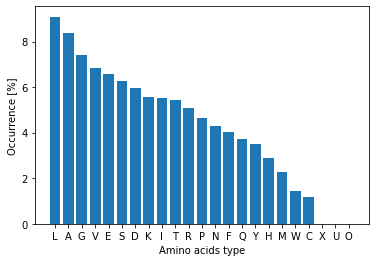

In [29]:
visualizer.visualize_occurrence(feature_series=processes_sequeces.seq, xlabel='Amino acids type').show()

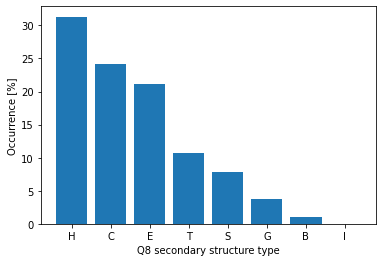

In [30]:
visualizer.visualize_occurrence(feature_series=processes_sequeces.sst_q8, xlabel='Q8 secondary structure type').show()

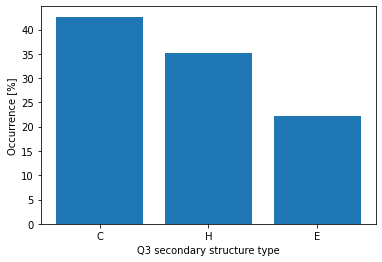

In [31]:
visualizer.visualize_occurrence(feature_series=processes_sequeces.sst_q3, xlabel='Q3 secondary structure type').show()

In [ ]:
x